## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [602]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm
from scipy.linalg import sqrtm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\ket{1}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\ket{1}$).
- The outcome of the measurement is then in the Hadamard basis.

Estimate a density matrix based on the binary (either 0 or 1) measurement outcomes of the quantum circuit

In [603]:
target_states = {
    '1': np.array([0, 1]),
    '+': (1/np.sqrt(2)) * np.array([+1, +1]),
    '-': (1/np.sqrt(2)) * np.array([+1, -1]),
}

In [604]:
def get_dm(state: np.ndarray) -> np.ndarray:
    return np.outer(state, np.conj(state))

def get_fidelity(rho, sigma):
    """
    Compute the fidelity between two quantum states represented by density matrices.
    
    Parameters:
    - rho (numpy.ndarray): Density matrix of the first quantum state.
    - sigma (numpy.ndarray): Density matrix of the second quantum state.
    
    Returns:
    - float: Fidelity between the two quantum states.
    
    Note:
    This function assumes that the input density matrices are valid (positive, trace 1) and of the same size.
    """
    
    # Computing the square root of rho
    sqrt_rho = sqrtm(rho)
    
    # Calculating the product sqrt_rho * sigma * sqrt_rho
    temp_product = np.dot(np.dot(sqrt_rho, sigma), sqrt_rho)
    
    # Taking the square root of the product
    root_product = sqrtm(temp_product)
    
    # Calculating the trace
    fidelity = np.real(np.trace(root_product))**2
    
    return fidelity

# Testing with example pure states, here orthogonal states (F = 0)
psi = np.array([1, 0])
phi = np.array([1, 0])

psi_dm = get_dm(state=psi)
phi_dm = get_dm(state=phi)

print(f'Fidelity F = {round(get_fidelity(psi_dm, phi_dm), 6)}')  # This should be close to 0 for orthogonal states

Fidelity F = 1.0


In [605]:
def estimate_dm(qc, estimated_dm, batch) -> np.ndarray:
    # Construct the estimated density matrix
    q_state = qi.Statevector.from_instruction(qc)
    estimated_dm += np.array(q_state.to_operator()) / batch 

    return estimated_dm

In [606]:
target_state_str = '+'

target_state = target_states[target_state_str]
print('Target state:', target_state)

Target state: [0.70710678 0.70710678]


In [607]:
def perform_action(amp, shots=1, target_state_str=target_state_str):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm, target_states
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    estimated_dm = np.zeros([2,2], dtype='complex128')

    for ind, angle in enumerate(angles):
        if target_state_str == '1':
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            estimate_dm(qc, estimated_dm, batch)
            
        elif target_state_str == '+':
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch  
            estimate_dm(qc, estimated_dm, batch)
            qc.h(0) # Transform to hadamard basis before measurement
            
        elif target_state_str == '-':
            qc.ry(2 * np.pi * angle, 0)
            estimate_dm(qc, estimated_dm, batch)
            qc.z(0)  # Apply Z gate for the minus state
            qc.h(0) # Transform to hadamard basis before measurement
        
        qc.measure(0, 0)  # Measurement
        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key
        
        # Calculate reward
        if target_state_str == '1':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target_state_str in ['+', '-']:
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))
        else:
            if ind % 10 == 0:
                print('!! Reward calculation FAILS !!')

        qc.clear()

    return reward_table, estimated_dm

#### Set Hyperparameters for the RL

In [608]:
# Variables to define environment
qc = QuantumCircuit(1, 1)  # Two-level system of interest, 1 qubit
qasm = QasmSimulator(method="statevector")  # Simulation backend (mock quantum computer)

seed = 2364

# Hyperparameters for the agent
n_epochs = 200
batch_size = 50
eta = 0.01  # Learning rate for policy update step

# Policy parameters
mu = nn.Parameter(torch.randn([]) * 0.05)  # Initializing mu with a value drawn from a normal distribution with mean 0, sigma 0.05
sigma = nn.Parameter(torch.tensor(0.05))  # Initializing sigma with a value of 0.05

# Critic parameter (single state-independent baseline b)
b = nn.Parameter(torch.tensor(0.))

#### Training

In [609]:
def constrain_mu(value, min_val, max_val):
    return torch.clamp(value, min_val, max_val)

def constrain_sigma(value):
    return torch.relu(value) # Ensures that sigma is non-negative

In [610]:
def log_info(epoch, mu, sigma, reward, target_state, fidelity):
    print('\nEPOCH', epoch+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())
    print('Average Return:', reward.mean().item())
    print('Target state: ', target_state)
    print('Fidelity: ', fidelity)

In [613]:
# Create an optimizer for the trainable parameters
optimizer = optim.Adam([mu, sigma, b], lr=eta)
epsilon = 1e-3 # Small offset to avoid sigma = 0
 # Clip the gradients
grad_clip = 0.3


# Dictionary to keep track of the used parameters
params = {
            'mu': [],
            'sigma': [],
            'reward': [],
            'fidelity': [],
            'learning_rate': eta,
            'seed': seed,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
}

### Training loop
for epoch in tqdm(range(n_epochs)):

    # Sample action from policy (Gaussian distribution with parameters mu and sigma)
    Normal_distrib = Normal(loc=mu, scale=sigma + epsilon)
    action = Normal_distrib.sample((batch_size,)) # action 

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward, estimated_dm = perform_action(action, shots=1, target_state_str=target_state_str)
    target_state_dm = get_dm(target_states[target_state_str])
    fidelity = get_fidelity(target_state_dm, estimated_dm)
    
    if epoch % 10 == 0:
        log_info(epoch, mu, sigma, reward, target_state, fidelity) 

    advantage = torch.tensor(reward, dtype=torch.float32) - b
    
    log_probs = Normal_distrib.log_prob(action)

    actor_loss = -(advantage * log_probs).mean()
    critic_loss = (advantage ** 2).mean()
    critic_loss_coeff = 0.5
    combined_loss = actor_loss + critic_loss_coeff * critic_loss

    # Clear previous gradients
    optimizer.zero_grad() 
    # Backpropagation
    combined_loss.backward()
    # Clip the gradients
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)
    # Apply gradients
    optimizer.step()

    # During training, after each optimizer step:
    with torch.no_grad():
        mu.data = constrain_mu(mu.data, -2., 2.)
        sigma.data = constrain_sigma(sigma.data)
  
    params["mu"].append(mu.item())
    params["sigma"].append(sigma.item())
    params["reward"].append(reward)
    params["fidelity"].append(fidelity)

  2%|▎         | 5/200 [00:00<00:04, 42.00it/s]


EPOCH 1
Policy parameter
mu = -0.013979039154946804 +- sigma = 0.01123788207769394
baseline -0.8699001669883728
Average Return: -0.04
Target state:  [0.70710678 0.70710678]
Fidelity:  0.6738929880761632


  8%|▊         | 17/200 [00:00<00:03, 48.76it/s]


EPOCH 11
Policy parameter
mu = 0.06995785236358643 +- sigma = 0.07579579204320908
baseline -0.9577151536941528
Average Return: 0.28
Target state:  [0.70710678 0.70710678]
Fidelity:  0.8445670933209158

EPOCH 21
Policy parameter
mu = 0.16350547969341278 +- sigma = 0.0636439397931099
baseline -0.953951895236969
Average Return: 0.68
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9463819772361661


 20%|██        | 41/200 [00:00<00:03, 51.29it/s]


EPOCH 31
Policy parameter
mu = 0.22786329686641693 +- sigma = 0.01777627132833004
baseline -0.8947256207466125
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9954937697636007

EPOCH 41
Policy parameter
mu = 0.22841796278953552 +- sigma = 0.014461084268987179
baseline -0.8958829641342163
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9962912109547089


 30%|██▉       | 59/200 [00:01<00:02, 51.57it/s]


EPOCH 51
Policy parameter
mu = 0.21192717552185059 +- sigma = 0.030172334983944893
baseline -0.9347636103630066
Average Return: 0.92
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9883336563588954

EPOCH 61
Policy parameter
mu = 0.1884525716304779 +- sigma = 0.05981764197349548
baseline -0.9498903751373291
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9659964779368235


 38%|███▊      | 77/200 [00:01<00:02, 50.94it/s]


EPOCH 71
Policy parameter
mu = 0.19603806734085083 +- sigma = 0.047239840030670166
baseline -0.909067690372467
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9707125590168315


 44%|████▍     | 89/200 [00:01<00:02, 49.81it/s]


EPOCH 81
Policy parameter
mu = 0.21247504651546478 +- sigma = 0.021196400746703148
baseline -0.8614609837532043
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9903760145752339

EPOCH 91
Policy parameter
mu = 0.23397526144981384 +- sigma = 0.0
baseline -0.8751929998397827
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9987226185533209


 54%|█████▎    | 107/200 [00:02<00:01, 51.36it/s]


EPOCH 101
Policy parameter
mu = 0.24870918691158295 +- sigma = 0.0
baseline -0.8988184332847595
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9999868825404211

EPOCH 111
Policy parameter
mu = 0.24917392432689667 +- sigma = 0.0
baseline -0.9399032592773438
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9999913963196214


 66%|██████▌   | 131/200 [00:02<00:01, 51.96it/s]


EPOCH 121
Policy parameter
mu = 0.2478644996881485 +- sigma = 0.0
baseline -0.9814208149909973
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9999700892404069

EPOCH 131
Policy parameter
mu = 0.2689596712589264 +- sigma = 0.0
baseline -1.014737844467163
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9982399026053034


 74%|███████▍  | 149/200 [00:02<00:00, 52.05it/s]


EPOCH 141
Policy parameter
mu = 0.2572733163833618 +- sigma = 0.010278487578034401
baseline -1.0556586980819702
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9989853643880865

EPOCH 151
Policy parameter
mu = 0.27383989095687866 +- sigma = 0.011028358712792397
baseline -1.104423999786377
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9959803837568683


 84%|████████▎ | 167/200 [00:03<00:00, 51.54it/s]


EPOCH 161
Policy parameter
mu = 0.29969310760498047 +- sigma = 0.0055506364442408085
baseline -1.172611117362976
Average Return: 0.88
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9872164826718809

EPOCH 171
Policy parameter
mu = 0.3296590745449066 +- sigma = 0.007406669668853283
baseline -1.2521554231643677
Average Return: 1.0
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9681601390922083


 96%|█████████▌| 191/200 [00:03<00:00, 51.64it/s]


EPOCH 181
Policy parameter
mu = 0.3285258412361145 +- sigma = 0.005331770051270723
baseline -1.3166965246200562
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9701051820411228

EPOCH 191
Policy parameter
mu = 0.3043806552886963 +- sigma = 0.014879373833537102
baseline -1.3702878952026367
Average Return: 0.96
Target state:  [0.70710678 0.70710678]
Fidelity:  0.9832422746665803


100%|██████████| 200/200 [00:03<00:00, 50.95it/s]


#### Visualization

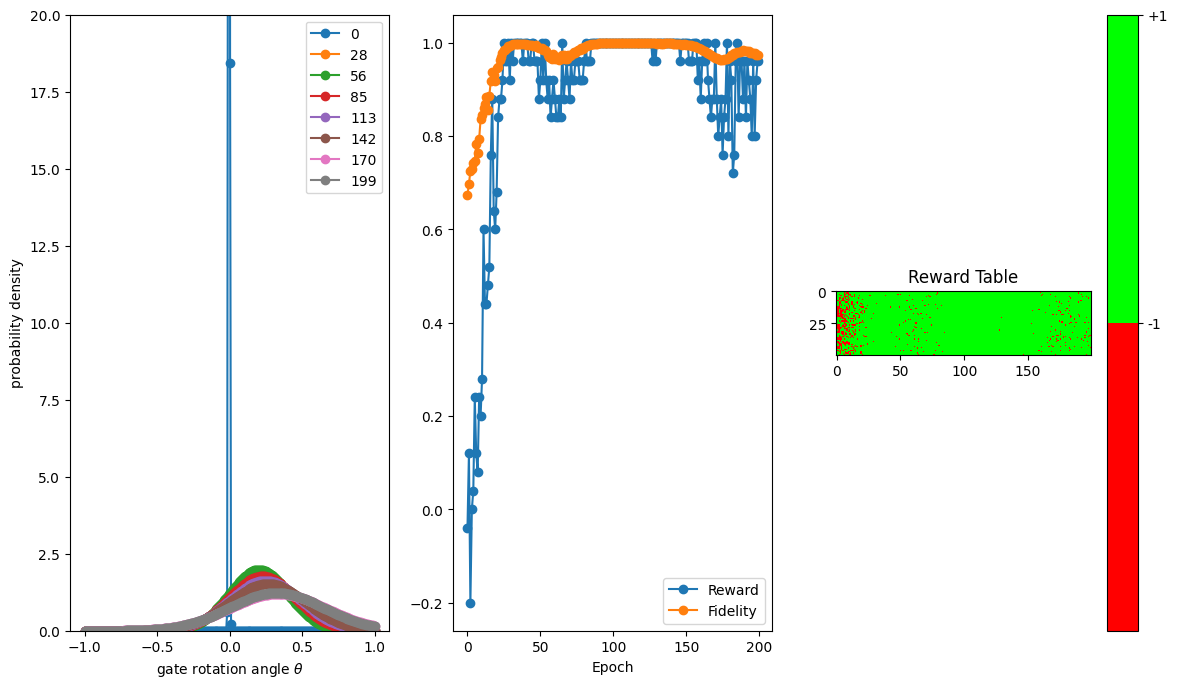

In [614]:
x = np.linspace(-1., 1., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))
# Plot probability density associated to updated parameters for a few steps
for i in np.linspace(0, n_epochs-1, n_epochs//25, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][i], scale=np.abs(params["mu"][i])), '-o', label=f'{i}')

ax1.set_xlabel(r"gate rotation angle $\theta$")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
ax2.plot(params["fidelity"], '-o', label='Fidelity')
ax2.set_xlabel("Epoch")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()